## Import TensorFlow and other libraries

In [26]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input, Dense, Conv2D, Add, Dropout
from tensorflow.keras.layers import SeparableConv2D, ReLU
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model
from tensorflow.keras import regularizers, optimizers

image_size = 512
classes = 4
bs = 16

dropout_rate = 0.25
reg_rate = 0.001

!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

## Dataset Split  

In [5]:
train_path = '/home/ahmedf/Downloads/classified_19/original_classes/'
training_checkpoints_path = '/home/ahmedf/Downloads/classified_19/training_checkpoints_original'

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=bs,
  label_mode="int",
  shuffle=True)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=bs,
  label_mode="int",
  shuffle=True)

Found 14968 files belonging to 4 classes.
Using 11975 files for training.
Found 14968 files belonging to 4 classes.
Using 2993 files for validation.


## Data Augmentation 

In [40]:
train_ds.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32),label)).cache(
            ).map(lambda image, label: (tf.image.random_flip_left_right(image), label)
            ).map(lambda image, label: (tf.image.random_contrast(image, lower=0.0, upper=1.0), label)
            ).map(lambda image, label:  (tf.image.random_crop(image, size=[4,image_size,image_size,3]), label)
            ).shuffle(1000).batch(bs).repeat(2)

<RepeatDataset shapes: ((None, 4, 512, 512, 3), (None, None)), types: (tf.float32, tf.int32)>

In [41]:
val_ds.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32),label)).cache(
            ).map(lambda image, label: (tf.image.random_flip_left_right(image), label)
            ).map(lambda image, label: (tf.image.random_contrast(image, lower=0.0, upper=1.0), label)
            ).map(lambda image, label:  (tf.image.random_crop(image, size=[4,image_size,image_size,3]), label)
            ).shuffle(1000).batch(bs).repeat(2)

<RepeatDataset shapes: ((None, 4, 512, 512, 3), (None, None)), types: (tf.float32, tf.int32)>

# Model Architecture

In [42]:
def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False,
               kernel_regularizer=regularizers.L2(reg_rate))(x)
    x = BatchNormalization()(x)
    
    return x

In [43]:
def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False,
                        kernel_regularizer=regularizers.L2(reg_rate))(x)
    x = BatchNormalization()(x)
    return x

In [44]:
def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = Dropout(dropout_rate)(x)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

In [45]:
def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = Dropout(dropout_rate)(x)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor

In [46]:
def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = Dropout(dropout_rate)(x)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = classes, activation = 'softmax')(x)
    
    return x

In [47]:
input = Input(shape = (image_size,image_size,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training the Model 

In [48]:
adam = optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)

weights_path = train_path + 'weights.hdf5'

mcp = callbacks.ModelCheckpoint(train_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max', save_freq=50)
callbacks_list = [mcp]

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=adam, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [55]:
with tf.device('/device:GPU:0'):
    hist = model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=50, batch_size=bs, callbacks=callbacks_list, shuffle=True)
    
checkpoint = tf.train.Checkpoint(model)
save_path = checkpoint.save(training_checkpoints_path)

Epoch 1/50
749/749 [==============================] - 1356s 2s/step - loss: 0.8674 - sparse_categorical_accuracy: 0.6641 - val_loss: 1.0582 - val_sparse_categorical_accuracy: 0.5857
Epoch 2/50
749/749 [==============================] - 1353s 2s/step - loss: 0.8440 - sparse_categorical_accuracy: 0.6744 - val_loss: 1.5843 - val_sparse_categorical_accuracy: 0.5723
Epoch 3/50
372/749 [=============>................] - ETA: 10:29 - loss: 0.8462 - sparse_categorical_accuracy: 0.6714WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1345s 2s/step - loss: 0.8331 - sparse_categorical_accuracy: 0.6765 - val_loss: 1.2660 - val_sparse_categorical_accuracy: 0.5700
Epoch 4/50
749/749 [==============================] - 1350s 2s/step - loss: 0.8001 - sparse_categorical_accuracy: 0.6898 - val_loss: 2.1114 - val_sparse_categorical_accuracy: 0.4651
Epoch 5/50
749/749 [==============================] - 1350s 2s/step - loss: 0.7905 - sparse_categorical_accuracy: 0.6944 - val_loss: 1.1510 - val_sparse_categorical_accuracy: 0.5964


Epoch 6/50
749/749 [==============================] - 1353s 2s/step - loss: 0.7787 - sparse_categorical_accuracy: 0.7020 - val_loss: 1.3592 - val_sparse_categorical_accuracy: 0.5857
Epoch 7/50
749/749 [==============================] - 1357s 2s/step - loss: 0.7568 - sparse_categorical_accuracy: 0.7145 - val_loss: 1.3869 - val_sparse_categorical_accuracy: 0.4678
Epoch 8/50
377/749 [==============>...............] - ETA: 10:24 - loss: 0.7499 - sparse_categorical_accuracy: 0.7150WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1351s 2s/step - loss: 0.7327 - sparse_categorical_accuracy: 0.7225 - val_loss: 2.1330 - val_sparse_categorical_accuracy: 0.5065
Epoch 9/50
749/749 [==============================] - 1356s 2s/step - loss: 0.7032 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.9248 - val_sparse_categorical_accuracy: 0.6662
Epoch 10/50
749/749 [==============================] - 1350s 2s/step - loss: 0.6734 - sparse_categorical_accuracy: 0.7503 - val_loss: 1.6759 - val_sparse_categorical_accuracy: 0.4517


Epoch 11/50
749/749 [==============================] - 1347s 2s/step - loss: 0.6475 - sparse_categorical_accuracy: 0.7620 - val_loss: 1.0813 - val_sparse_categorical_accuracy: 0.6218
Epoch 12/50
749/749 [==============================] - 1359s 2s/step - loss: 0.6256 - sparse_categorical_accuracy: 0.7749 - val_loss: 1.1056 - val_sparse_categorical_accuracy: 0.6161
Epoch 13/50
382/749 [==============>...............] - ETA: 10:13 - loss: 0.6121 - sparse_categorical_accuracy: 0.7786WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1355s 2s/step - loss: 0.6026 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.9359 - val_sparse_categorical_accuracy: 0.6739
Epoch 14/50
749/749 [==============================] - 1349s 2s/step - loss: 0.5560 - sparse_categorical_accuracy: 0.8068 - val_loss: 1.6859 - val_sparse_categorical_accuracy: 0.5436
Epoch 15/50
749/749 [==============================] - 1352s 2s/step - loss: 0.5175 - sparse_categorical_accuracy: 0.8150 - val_loss: 1.0619 - val_sparse_categorical_accuracy: 0.6742


Epoch 16/50
749/749 [==============================] - 1357s 2s/step - loss: 0.4868 - sparse_categorical_accuracy: 0.8338 - val_loss: 0.9600 - val_sparse_categorical_accuracy: 0.6762
Epoch 17/50
749/749 [==============================] - 1349s 2s/step - loss: 0.4568 - sparse_categorical_accuracy: 0.8472 - val_loss: 2.1001 - val_sparse_categorical_accuracy: 0.5379
Epoch 18/50
387/749 [==============>...............] - ETA: 10:03 - loss: 0.4350 - sparse_categorical_accuracy: 0.8597WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1351s 2s/step - loss: 0.4253 - sparse_categorical_accuracy: 0.8635 - val_loss: 1.5388 - val_sparse_categorical_accuracy: 0.5951
Epoch 19/50
749/749 [==============================] - 1345s 2s/step - loss: 0.4037 - sparse_categorical_accuracy: 0.8722 - val_loss: 1.7046 - val_sparse_categorical_accuracy: 0.6104
Epoch 20/50
749/749 [==============================] - 1351s 2s/step - loss: 0.3776 - sparse_categorical_accuracy: 0.8828 - val_loss: 1.6956 - val_sparse_categorical_accuracy: 0.5767


Epoch 21/50
749/749 [==============================] - 1345s 2s/step - loss: 0.3717 - sparse_categorical_accuracy: 0.8894 - val_loss: 1.8786 - val_sparse_categorical_accuracy: 0.5737
Epoch 22/50
749/749 [==============================] - 1351s 2s/step - loss: 0.3418 - sparse_categorical_accuracy: 0.8982 - val_loss: 2.6542 - val_sparse_categorical_accuracy: 0.4841
Epoch 23/50
392/749 [==============>...............] - ETA: 9:54 - loss: 0.3351 - sparse_categorical_accuracy: 0.8960WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1355s 2s/step - loss: 0.3282 - sparse_categorical_accuracy: 0.9015 - val_loss: 1.6384 - val_sparse_categorical_accuracy: 0.5910
Epoch 24/50
749/749 [==============================] - 1351s 2s/step - loss: 0.3217 - sparse_categorical_accuracy: 0.9106 - val_loss: 1.5897 - val_sparse_categorical_accuracy: 0.5790
Epoch 25/50
749/749 [==============================] - 1348s 2s/step - loss: 0.3031 - sparse_categorical_accuracy: 0.9147 - val_loss: 1.8368 - val_sparse_categorical_accuracy: 0.5924


Epoch 26/50
749/749 [==============================] - 1356s 2s/step - loss: 0.2974 - sparse_categorical_accuracy: 0.9172 - val_loss: 2.8254 - val_sparse_categorical_accuracy: 0.5282
Epoch 27/50
749/749 [==============================] - 1345s 2s/step - loss: 0.2661 - sparse_categorical_accuracy: 0.9285 - val_loss: 1.9739 - val_sparse_categorical_accuracy: 0.6358
Epoch 28/50
397/749 [==============>...............] - ETA: 9:48 - loss: 0.3005 - sparse_categorical_accuracy: 0.9169WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1350s 2s/step - loss: 0.2779 - sparse_categorical_accuracy: 0.9233 - val_loss: 1.7496 - val_sparse_categorical_accuracy: 0.6335
Epoch 29/50
749/749 [==============================] - 1339s 2s/step - loss: 0.2535 - sparse_categorical_accuracy: 0.9322 - val_loss: 2.1852 - val_sparse_categorical_accuracy: 0.6191
Epoch 30/50
749/749 [==============================] - 1337s 2s/step - loss: 0.2517 - sparse_categorical_accuracy: 0.9326 - val_loss: 2.2257 - val_sparse_categorical_accuracy: 0.5910


Epoch 31/50
749/749 [==============================] - 1333s 2s/step - loss: 0.2416 - sparse_categorical_accuracy: 0.9357 - val_loss: 1.5573 - val_sparse_categorical_accuracy: 0.6392
Epoch 32/50
749/749 [==============================] - 1350s 2s/step - loss: 0.2474 - sparse_categorical_accuracy: 0.9363 - val_loss: 1.6475 - val_sparse_categorical_accuracy: 0.5994
Epoch 33/50
402/749 [===============>..............] - ETA: 9:34 - loss: 0.2268 - sparse_categorical_accuracy: 0.9415WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1350s 2s/step - loss: 0.2151 - sparse_categorical_accuracy: 0.9448 - val_loss: 1.5392 - val_sparse_categorical_accuracy: 0.6418
Epoch 34/50
749/749 [==============================] - 1352s 2s/step - loss: 0.2455 - sparse_categorical_accuracy: 0.9390 - val_loss: 2.2553 - val_sparse_categorical_accuracy: 0.5737
Epoch 35/50
749/749 [==============================] - 1342s 2s/step - loss: 0.2240 - sparse_categorical_accuracy: 0.9441 - val_loss: 2.8001 - val_sparse_categorical_accuracy: 0.4534
Epoch 36/50
  5/749 [..............................] - ETA: 21:47 - loss: 0.2414 - sparse_categorical_accuracy: 0.9375WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1345s 2s/step - loss: 0.2082 - sparse_categorical_accuracy: 0.9482 - val_loss: 1.8918 - val_sparse_categorical_accuracy: 0.6385
Epoch 37/50
749/749 [==============================] - 1351s 2s/step - loss: 0.2241 - sparse_categorical_accuracy: 0.9465 - val_loss: 2.1861 - val_sparse_categorical_accuracy: 0.6061
Epoch 38/50
407/749 [===============>..............] - ETA: 9:30 - loss: 0.1938 - sparse_categorical_accuracy: 0.9516WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1346s 2s/step - loss: 0.2028 - sparse_categorical_accuracy: 0.9497 - val_loss: 1.6299 - val_sparse_categorical_accuracy: 0.6478
Epoch 39/50
749/749 [==============================] - 1352s 2s/step - loss: 0.2118 - sparse_categorical_accuracy: 0.9506 - val_loss: 1.5632 - val_sparse_categorical_accuracy: 0.6702
Epoch 40/50
749/749 [==============================] - 1357s 2s/step - loss: 0.1978 - sparse_categorical_accuracy: 0.9517 - val_loss: 2.3018 - val_sparse_categorical_accuracy: 0.5700
Epoch 41/50
 10/749 [..............................] - ETA: 19:34 - loss: 0.2741 - sparse_categorical_accuracy: 0.9438WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1353s 2s/step - loss: 0.2181 - sparse_categorical_accuracy: 0.9470 - val_loss: 2.5023 - val_sparse_categorical_accuracy: 0.5356
Epoch 42/50
749/749 [==============================] - 1351s 2s/step - loss: 0.1930 - sparse_categorical_accuracy: 0.9536 - val_loss: 2.8311 - val_sparse_categorical_accuracy: 0.5657
Epoch 43/50
412/749 [===============>..............] - ETA: 9:25 - loss: 0.2136 - sparse_categorical_accuracy: 0.9518WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1355s 2s/step - loss: 0.1990 - sparse_categorical_accuracy: 0.9527 - val_loss: 1.5181 - val_sparse_categorical_accuracy: 0.6225
Epoch 44/50
749/749 [==============================] - 1357s 2s/step - loss: 0.1867 - sparse_categorical_accuracy: 0.9600 - val_loss: 1.6292 - val_sparse_categorical_accuracy: 0.5840
Epoch 45/50
749/749 [==============================] - 1354s 2s/step - loss: 0.1950 - sparse_categorical_accuracy: 0.9570 - val_loss: 1.2726 - val_sparse_categorical_accuracy: 0.6766
Epoch 46/50
 15/749 [..............................] - ETA: 19:55 - loss: 0.2081 - sparse_categorical_accuracy: 0.9583WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1347s 2s/step - loss: 0.1824 - sparse_categorical_accuracy: 0.9576 - val_loss: 5.8078 - val_sparse_categorical_accuracy: 0.4845
Epoch 47/50
749/749 [==============================] - 1348s 2s/step - loss: 0.2256 - sparse_categorical_accuracy: 0.9481 - val_loss: 1.3688 - val_sparse_categorical_accuracy: 0.6759
Epoch 48/50
417/749 [===============>..............] - ETA: 9:15 - loss: 0.2067 - sparse_categorical_accuracy: 0.9532WARNING:tensorflow:Can save best model only with val_sparse_categorical_accuracy available, skipping.


749/749 [==============================] - 1357s 2s/step - loss: 0.1894 - sparse_categorical_accuracy: 0.9564 - val_loss: 1.3398 - val_sparse_categorical_accuracy: 0.6739
Epoch 49/50
749/749 [==============================] - 1354s 2s/step - loss: 0.1846 - sparse_categorical_accuracy: 0.9606 - val_loss: 1.7480 - val_sparse_categorical_accuracy: 0.6331
Epoch 50/50
749/749 [==============================] - 1351s 2s/step - loss: 0.1887 - sparse_categorical_accuracy: 0.9631 - val_loss: 1.8252 - val_sparse_categorical_accuracy: 0.5907


### Model Evalutation

In [56]:
preds = model.evaluate(val_ds, batch_size=bs, verbose=1, sample_weight=None)

188/188 [==============================] - 100s 528ms/step - loss: 1.8252 - sparse_categorical_accuracy: 0.5907


### Results (Accurancy and Loss) 

Text(0.5, 1.0, 'Accuracy')

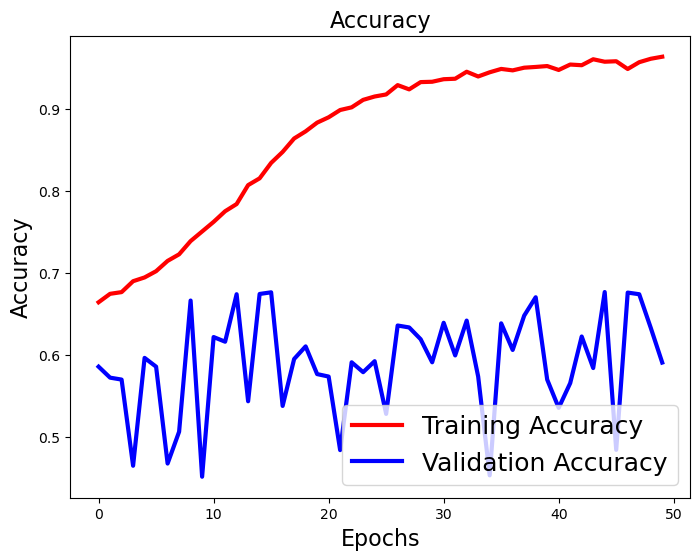

In [57]:
#Trial 3: dropot = 0.25 -- reg = 0.001 -- Adam - shuffle data in
fig = plt.figure(figsize=[8, 6])

results_type = 'Accuracy'
plt.plot(hist.history['sparse_categorical_accuracy'], 'r', linewidth=3.0)
plt.plot(hist.history['val_sparse_categorical_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel(results_type, fontsize=16)
plt.title(results_type, fontsize=16)

Text(0.5, 1.0, 'Loss')

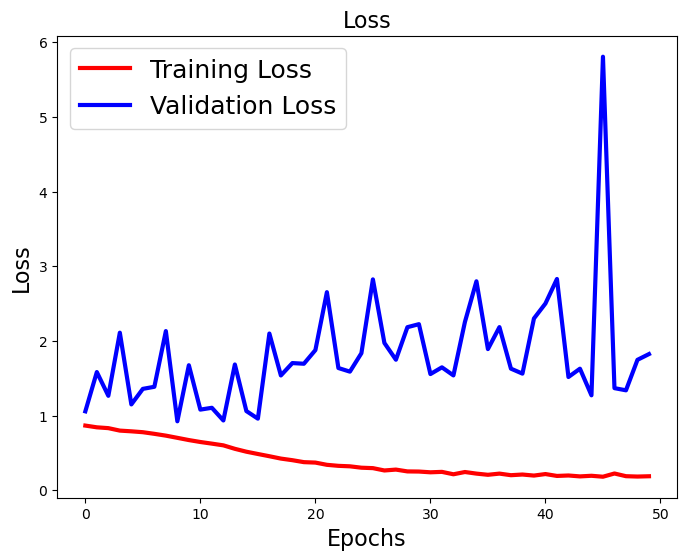

In [58]:
fig = plt.figure(figsize=[8, 6])

results_type = 'Loss'
plt.plot(hist.history['loss'], 'r', linewidth=3.0)
plt.plot(hist.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel(results_type, fontsize=16)
plt.title(results_type, fontsize=16)

Text(0.5, 1.0, 'Accuracy')

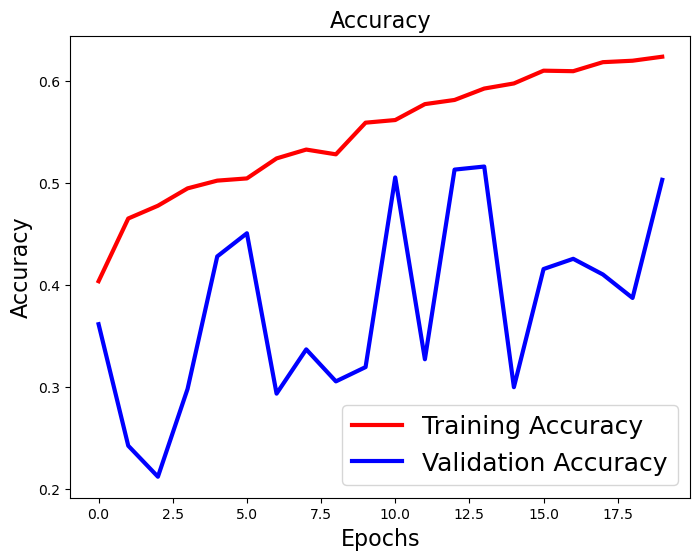

In [57]:
### Trial 2: dropot = 0.2 -- reg = 0.1 -- SGD
fig = plt.figure(figsize=[8, 6])

results_type = 'Accuracy'
plt.plot(hist.history['sparse_categorical_accuracy'], 'r', linewidth=3.0)
plt.plot(hist.history['val_sparse_categorical_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel(results_type, fontsize=16)
plt.title(results_type, fontsize=16)

Text(0.5, 1.0, 'Loss')

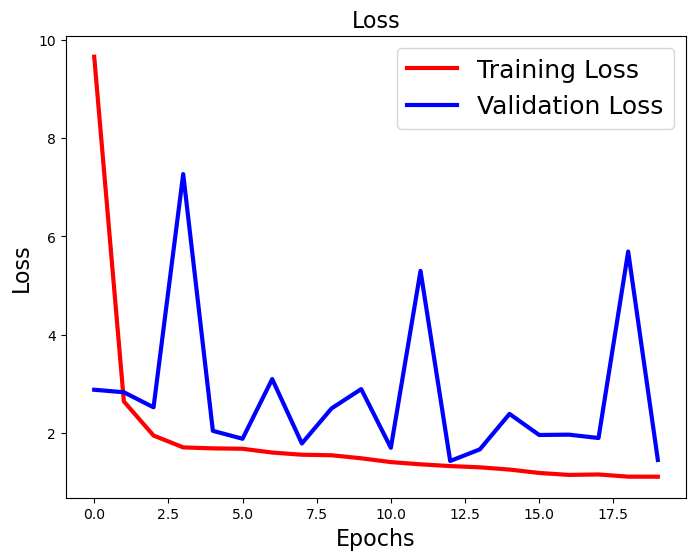

In [59]:
fig = plt.figure(figsize=[8, 6])

results_type = 'Loss'
plt.plot(hist.history['loss'], 'r', linewidth=3.0)
plt.plot(hist.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel(results_type, fontsize=16)
plt.title(results_type, fontsize=16)

Text(0.5, 1.0, 'Accuracy')

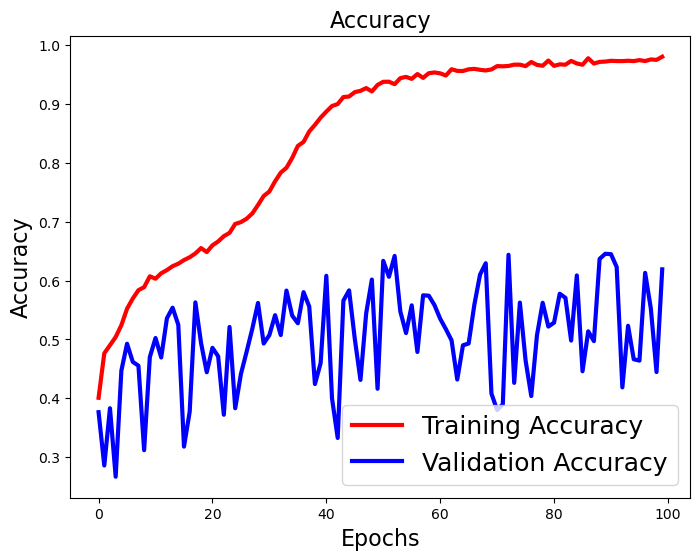

In [26]:
#Trial 1: dropot = 0.1 -- reg = 0.05 -- a=Adam
fig = plt.figure(figsize=[8, 6])

results_type = 'Accuracy'
plt.plot(hist.history['sparse_categorical_accuracy'], 'r', linewidth=3.0)
plt.plot(hist.history['val_sparse_categorical_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel(results_type, fontsize=16)
plt.title(results_type, fontsize=16)

### Resotore Checkpoints

In [1]:
checkpoint.restore(tf.train.latest_checkpoint(training_checkpoints_path))